In [1]:
%matplotlib inline

import sys
import os

# Add root project directory to path if needed, since in notebook directory
if not any([path.endswith('./../') for path in sys.path]):
    sys.path.insert(0, os.path.join(os.getcwd(), './../'))    

import requests
import io
import os
import s3fs
import glob

import dask.dataframe as dd
import pandas as pd
import numpy as np

from dask import delayed
from distributed import Client
from distributed import progress, wait
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from core.data_acquisition import TaxiData

clean_df = TaxiData.clean_df

# S3 File system
fs = s3fs.S3FileSystem(anon=True)

# Connection to the dask scheduler
client = Client('tcp://ec2-52-215-45-25.eu-west-1.compute.amazonaws.com:8786')
client.restart()
client

Client Scheduler: tcp://ec2-52-215-45-25.eu-west-1.compute.amazonaws.com:8786 Dashboard: http://ec2-52-215-45-25.eu-west-1.compute.amazonaws.com:8787,Cluster Workers: 18 Cores: 144 Memory: 283.84 GB


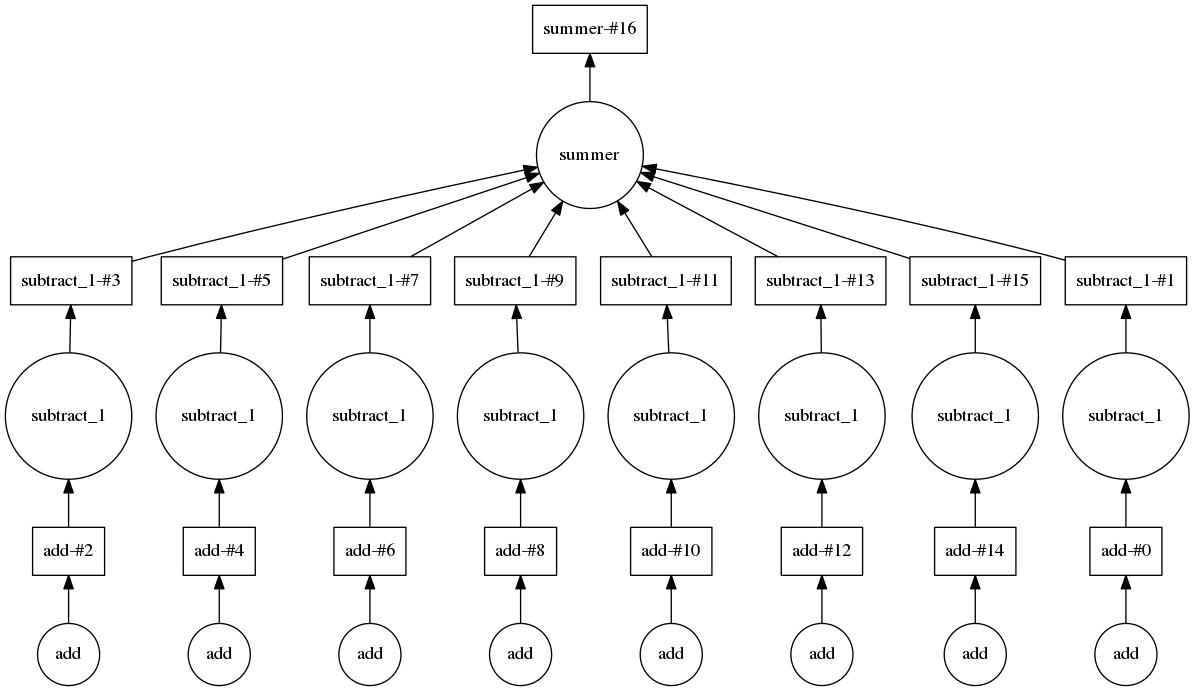

In [4]:
import time
import random

def add(x, y):
    time.sleep(random.random())
    return x + y

def subtract_1(x):
    time.sleep(random.random())
    return x - 1

def summer(arr):
    time.sleep(random.random())
    return sum(arr)
    
sub_results = []
for i in range(8):
    
    add_result = delayed(add)(i, i*2)
    subtract_result = delayed(subtract_1)(add_result)
    sub_results.append(subtract_result)
    
total = delayed(summer)(sub_results)
    
total.visualize()

In [5]:
total.compute()

76

## Read in and Look at Taxi Data...

In [6]:
df = dd.read_csv('s3://dask-data/nyc-taxi/2015/*.csv',
                 storage_options={'anon': True})
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
npartitions=365,,,,,,,,,,,,,,,,,,,
,int64,object,object,int64,float64,float64,float64,int64,object,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Nothing is actually computed, just meta data sampling, lets persist it to cluster RAM

In [7]:
df['tpep_pickup_datetime'] = dd.to_datetime(df.tpep_pickup_datetime, yearfirst=True, errors='coerce')
df['tpep_dropoff_datetime'] = dd.to_datetime(df.tpep_dropoff_datetime, yearfirst=True, errors='coerce')

df = client.persist(df)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [8]:
progress(df)

VBox()

Summary stats...

In [9]:
count = df.count()
count

Dask Series Structure:
npartitions=1
RateCodeID       int64
trip_distance      ...
dtype: int64
Dask Name: dataframe-count-agg, 731 tasks

In [10]:
count.compute().VendorID

146112989

In [11]:
df.total_amount.describe().compute().astype(int)

count    146112989
mean            16
std            356
min           -496
25%              9
50%             13
75%             20
max        3950611
dtype: int64

## How many are below 0 and how many are above the 99% quantile?

In [12]:
print('Count of fares below  0: ', df.where(df.total_amount < 0).VendorID.count().compute())
_99th_quantile = df.total_amount.quantile(q=0.99).compute()
print('99% quantile: ', _99th_quantile)
print('Count of fares over  99%: ', df.where(df.total_amount > _99th_quantile).VendorID.count().compute())

Count of fares below  0:  51463
99% quantile:  71.0
Count of fares over  99%:  863565


## Let's limit the data to fares between 0 and 55

In [13]:
df = df.where(df.total_amount.between(0, 70))
df.count().compute().VendorID

144788471

---
# A little bit of analysis...

## Do more passengers == longer distances?

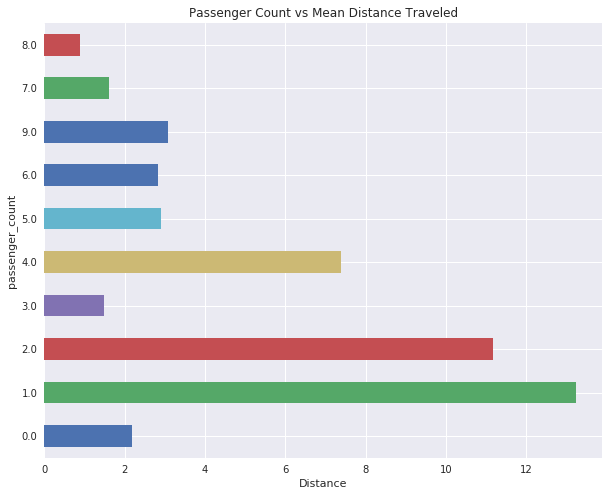

In [15]:
grouped = df.groupby(df.passenger_count).trip_distance.mean().compute()

plt.figure(figsize=(10, 8))
grouped.plot.barh()
plt.title('Passenger Count vs Mean Distance Traveled')
plt.xlabel('Distance')
plt.show()

### Average speed by hour, maybe?

In [16]:
# Calculate speed of trip
speed = (df.trip_distance / ((df.tpep_dropoff_datetime - df.tpep_pickup_datetime).astype('timedelta64[m]').astype(float) / 60))

# Replace inf values with NaNs
speed = speed.map(lambda val: val if val not in [np.inf, -np.inf] else np.NaN)

# Replace extreme values with NaNs
low = speed.quantile(q=0.01).compute()
high = speed.quantile(q=0.9).compute()
speed = speed.map(lambda val: val if low < val < high and not pd.isnull(val) else np.NaN)

# Assign columns
df['speed'] = speed
df['hour'] = df.tpep_pickup_datetime.dt.hour

df = client.persist(df)
progress(df)

VBox()

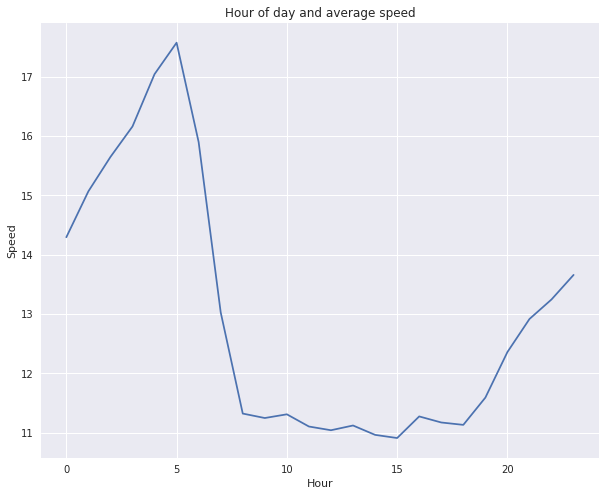

In [17]:
speed_by_hour = df.groupby('hour').speed.mean().compute()

plt.figure(figsize=(10, 8))
speed_by_hour.plot.line()
plt.xlabel('Hour')
plt.ylabel('Speed')
plt.title('Hour of day and average speed')
plt.grid(True)
plt.show()

## Does faster speed == better tip?

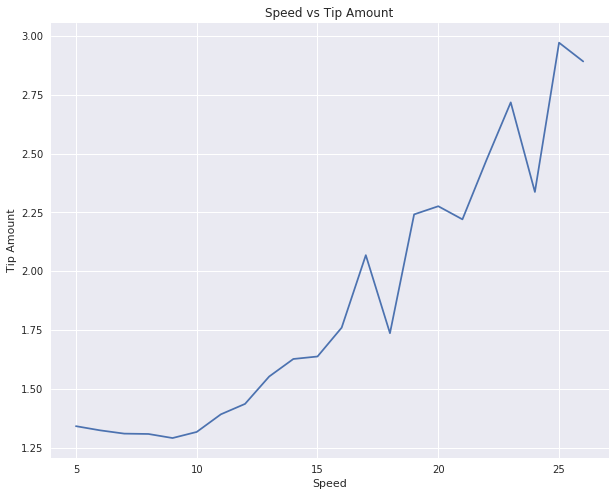

In [18]:
tmp = df.copy()

tmp = tmp.dropna(subset=['speed'])
tmp['speed_rounded'] = tmp.speed.map(lambda val: int(5 * (float(val) / 5)))
tips_by_speed = tmp.groupby('speed_rounded').tip_amount.mean().compute()

plt.figure(figsize=(10, 8))
tips_by_speed.plot.line()
plt.xlabel('Speed')
plt.ylabel('Tip Amount')
plt.title('Speed vs Tip Amount')
plt.grid(True)
plt.show()

## When are the best trip fractions?

In [19]:
df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]    # filter out bad rows
df2['tip_fraction'] = df2.tip_amount / df2.fare_amount  # make new column

dayofweek = (df2.groupby(df2.tpep_pickup_datetime.dt.dayofweek)
                .tip_fraction
                .mean()
            ).compute()
hour      = (df2.groupby(df2.tpep_pickup_datetime.dt.hour)
                .tip_fraction
                .mean()
            ).compute()

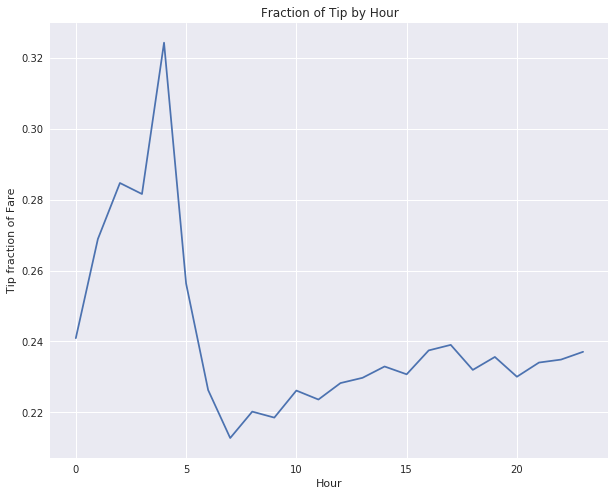

----- By Day of Week -----


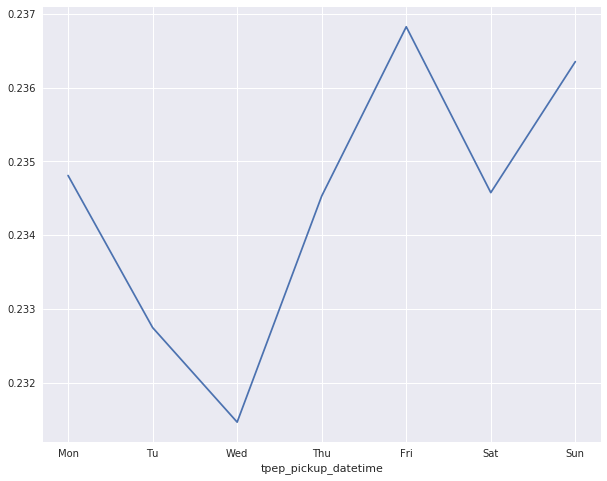

In [20]:
plt.figure(figsize=(10, 8))
hour.plot.line()
plt.ylabel('Tip fraction of Fare')
plt.xlabel('Hour')
plt.title('Fraction of Tip by Hour')
plt.show()

print('----- By Day of Week -----')

plt.figure(figsize=(10, 8))
ax = dayofweek.plot.line()
ax.set_xticklabels(['', 'Mon', 'Tu', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

## ML - Predict Tip Amount...

Here we make the X and y

In [21]:
exclude_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'VendorID', 'tip_amount',
                'RateCodeID', 'store_and_fwd_flag', 'payment_type']

X = df.copy()

X = X.dropna(subset=[c for c in X.columns if c not in exclude_cols])
y = X.tip_amount

for col in exclude_cols:
    del X[col]

X = client.persist(X)
y = client.persist(y)

X.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,speed,hour
0,1.0,1.59,-73.993896,40.750111,-73.974785,40.750618,12.0,1.0,0.5,0.0,0.3,17.05,5.300000,19.0
1,1.0,3.30,-74.001648,40.724243,-73.994415,40.759109,14.5,0.5,0.5,0.0,0.3,17.80,10.421053,20.0
2,1.0,1.80,-73.963341,40.802788,-73.951820,40.824413,9.5,0.5,0.5,0.0,0.3,10.80,10.800000,20.0
4,1.0,3.00,-73.971176,40.762428,-74.004181,40.742653,15.0,0.5,0.5,0.0,0.3,16.30,9.473684,20.0
6,1.0,2.20,-73.983276,40.726009,-73.992470,40.749634,14.0,0.5,0.5,0.0,0.3,15.30,5.500000,20.0


### Randomly split the data between training and testing

In [22]:
xTrain, xTest = X.random_split([0.7, 0.3], random_state=1234)
yTrain, yTest = y.random_split([0.7, 0.3], random_state=1234)

### Train the model and make predictions

In [23]:
import dask_xgboost as dxgb

# Define params and train model
params = {'objective': 'reg:linear'}
bst = dxgb.train(client, params, xTrain, yTrain)

# Make predictions using trained model
predictions = dxgb.predict(client, bst, xTest).persist()
predictions

/home/milesg/anaconda/envs/nyc-taxi-aws/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Dask Series Structure:
npartitions=365
    float32
        ...
     ...   
        ...
        ...
Name: predictions, dtype: float32
Dask Name: _predict_part, 365 tasks

### Make predictions (takes a long time...)

In [55]:
from sklearn.metrics import r2_score

y_true = yTest.compute()
pred = predictions.compute()
print('R2 of {:.4f}'.format(r2_score(y_true, pred)))

R2 of 0.8549


## Data processing script

In [3]:
import sys
counts = []

# Loop through years 2009-2017
for year in np.arange(2009, 2018):
    
    # Get only files pertaining to this year
    files = [f for f in fs.ls('nyc-tlc/trip data/') if str(year) in f and 'yellow' in f]
    
    # Process files in parallel. (client is asynchronous)
    for i, file in enumerate(files):
        
        # Extract year and month from filename
        _year, month = file[-11:-4].split('-')
        
        # Process data for current year and month
        df = dd.read_csv('s3://' + file, 
                         dtype='object',
                         error_bad_lines=False,
                         blocksize=int(128e6))
        df = df.map_partitions(clean_df)
        df = client.persist(df)
        
        # Yearly dataframe merging
        main_df = df if not i else main_df.append(df)
    
    # Write year's df to S3
    main_df.to_csv('s3://milesg-taxi-data-east/yellow-{year}-*.csv.gz'.format(year=year), compression='gzip')
    counts.append(main_df.passenger_count.count().compute())
    sys.stdout.write('\rYear: {} - Total {}'.format(_year, sum(counts)))
    
    # Clear from cluster memory
    client.cancel(main_df)


Year: 2017 - Total 1204768604

In [24]:
client.restart()

Client Scheduler: tcp://ec2-52-201-255-50.compute-1.amazonaws.com:8786 Dashboard: http://ec2-52-201-255-50.compute-1.amazonaws.com:8787,Cluster Workers: 8 Cores: 64 Memory: 269.92 GB


In [5]:
client.shutdown()